# Bitmask to polygonal annotation
This notebook contains functions that allow us to transform bitmasks to polygonal annotations in COCO format
## Main code

In [19]:
from PIL import Image # (pip install Pillow)
import matplotlib.pyplot as plt
import numpy as np                                 # (pip install numpy)
from skimage import measure                        # (pip install scikit-image)
from shapely.geometry import Polygon, MultiPolygon # (pip install Shapely)

### Submask creation
This function takes an image as an input, and creates a submask for each color in the image. The function returns a dictionary that has the color codes as keys and a submask as value

In [20]:
def create_sub_masks(mask_image):
    width, height = mask_image.size

    # Initialize a dictionary of sub-masks indexed by RGB colors
    sub_masks = {}
    for x in range(width):
        for y in range(height):
            # Get the RGB values of the pixel
            pixel = mask_image.getpixel((x,y))[:3]

            # If the pixel is not black...
            if pixel != (0, 0, 0):
                # Check to see if we've created a sub-mask...
                pixel_str = str(pixel)
                sub_mask = sub_masks.get(pixel_str)
                if sub_mask is None:
                   # Create a sub-mask (one bit per pixel) and add to the dictionary
                    # Note: we add 1 pixel of padding in each direction
                    # because the contours module doesn't handle cases
                    # where pixels bleed to the edge of the image
                    sub_masks[pixel_str] = Image.new('1', (width+2, height+2))

                # Set the pixel value to 1 (default is 0), accounting for padding
                sub_masks[pixel_str].putpixel((x+1, y+1), 1)

    return sub_masks

### Submask annotation
It takes the a dictionary consisting of color(key) and submask_image(value) and converts it into an annotation

In [21]:

def create_sub_mask_annotation(sub_mask, image_id, category_id, annotation_id, is_crowd):
    # Find contours (boundary lines) around each sub-mask
    # Note: there could be multiple contours if the object
    # is partially occluded. (E.g. an elephant behind a tree)
    contours = measure.find_contours(sub_mask, 0.5, positive_orientation='low')

    segmentations = []
    polygons = []
    for contour in contours:
        # Flip from (row, col) representation to (x, y)
        # and subtract the padding pixel
        for i in range(len(contour)):
            row, col = contour[i]
            contour[i] = (col - 1, row - 1)

        # Make a polygon and simplify it
        poly = Polygon(contour)
        poly = poly.simplify(1.0, preserve_topology=False)
        polygons.append(poly)
        segmentation = np.array(poly.exterior.coords).ravel().tolist()
        segmentations.append(segmentation)

    # Combine the polygons to calculate the bounding box and area
    multi_poly = MultiPolygon(polygons)
    x, y, max_x, max_y = multi_poly.bounds
    width = max_x - x
    height = max_y - y
    bbox = (x, y, width, height)
    area = multi_poly.area

    annotation = {
        'segmentation': segmentations,
        'iscrowd': is_crowd,
        'image_id': image_id,
        'category_id': category_id,
        'id': annotation_id,
        'bbox': bbox,
        'area': area
    }

    return annotation

### Implementing the function

In [22]:
import json

plant_book_mask_image = Image.open('plant_book_mask.png')
bottle_book_mask_image = Image.open('bottle_book_mask.png')
shapes = Image.open('shapes.png')
dog = Image.open('dog.png')

#mask_images = [plant_book_mask_image, bottle_book_mask_image]
mask_images = [img]

In [31]:
# Define which colors match which categories in the images
circle_id, square_id, dog_id, lamp_id = [1, 2, 3, 4]
category_ids = {
    1: {
        '(0, 255, 0)': square_id,
        '(255, 0, 0)': circle_id,
    },
    2: {
        '(0, 0, 255)': dog_id,
        '(255, 0, 0)': circle_id,
    }
}

In [32]:
is_crowd = 0

# These ids will be automatically increased as we go
annotation_id = 1
image_id = 1

In [33]:
# Create the annotations
annotations = []
for mask_image in mask_images:
    sub_masks = create_sub_masks(mask_image)
    for color, sub_mask in sub_masks.items():
        category_id = category_ids[image_id][color]
        annotation = create_sub_mask_annotation(np.array(sub_mask), image_id, category_id, annotation_id, is_crowd)
        annotations.append(annotation)
        annotation_id += 1
    image_id += 1

print(json.dumps(annotations))


[{"segmentation": [[122.0, 155.5, 136.0, 150.5, 148.5, 139.0, 152.5, 132.0, 155.5, 122.0, 155.5, 110.0, 150.5, 96.0, 139.0, 83.5, 132.0, 79.5, 122.0, 76.5, 110.0, 76.5, 96.0, 81.5, 83.5, 93.0, 79.5, 100.0, 76.5, 110.0, 76.5, 122.0, 81.5, 136.0, 93.0, 148.5, 100.0, 152.5, 110.0, 155.5, 122.0, 155.5]], "iscrowd": 0, "image_id": 1, "category_id": 1, "id": 1, "bbox": [76.5, 76.5, 79.0, 79.0], "area": 4901.5}, {"segmentation": [[278.0, 250.5, 278.5, 145.0, 173.0, 144.5, 172.5, 250.0, 278.0, 250.5]], "iscrowd": 0, "image_id": 1, "category_id": 2, "id": 2, "bbox": [172.5, 144.5, 106.0, 106.0], "area": 11130.5}]


## Test Code zone

(0, 0, 255)


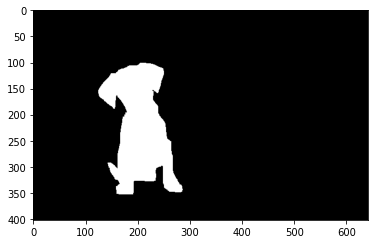

In [25]:

#plt.imshow(plant_book_mask_image)
#plt.show()
#print("Colors:{}".format(set(plant_book_mask_image.getdata())))
sub_masks = create_sub_masks(dog)
for color, sub_mask in sub_masks.items():
    print(color)
    plt.imshow(sub_mask)
    plt.show()


In [26]:
for mask_image in mask_images:
    sub_masks = create_sub_masks(mask_image)
    for color, sub_mask in sub_masks.items():
        category_id = category_ids[1][color])
        annotation = 

SyntaxError: invalid syntax (<ipython-input-26-8b1aa1191e99>, line 4)